In [1]:
import sys
sys.path.append("../src/data") 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from feature_builder import FeatureBuilder
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV, GroupKFold
from sklearn.metrics import accuracy_score, classification_report, log_loss, confusion_matrix

In [3]:
# Split the data into training, validation, and test sets if not already done
from generate_data_splits import generate_splits
generate_splits()

(1149, 246, 249)

In [5]:
# Load and preprocess the data
train_data = FeatureBuilder(file_path="../data/raw_splits/train_data.csv", normalize=False, exclude_columns=[]).build_features()
val_data = FeatureBuilder(file_path="../data/raw_splits/val_data.csv", normalize=False, exclude_columns=[]).build_features()
test_data = FeatureBuilder(file_path="../data/raw_splits/test_data.csv", normalize=False, exclude_columns=[]).build_features()

# Separate features (X) and labels (y)
X_train = train_data.drop(["id", "label"], axis=1)
y_train = train_data["label"]
X_val = val_data.drop(["id", "label"], axis=1)
y_val = val_data["label"]
X_test = test_data.drop(["id", "label"], axis=1)
y_test = test_data["label"]

d:\Personal Projects\311-ML-Food-Prediction\src\data\feature_builder.py:36: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.df = self.df.applymap(lambda x: x.lower())
d:\Personal Projects\311-ML-Food-Prediction\src\data\feature_builder.py:36: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.df = self.df.applymap(lambda x: x.lower())
d:\Personal Projects\311-ML-Food-Prediction\src\data\feature_builder.py:36: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.df = self.df.applymap(lambda x: x.lower())


In [6]:
print(X_train.columns)

Index(['q1_processed', 'q2_ingredient_count', 'q2_pizza_prob',
       'q2_shawarma_prob', 'q2_sushi_prob', 'q3_week_day_lunch',
       'q3_week_day_dinner', 'q3_weekend_lunch', 'q3_weekend_dinner',
       'q3_at_a_party', 'q3_late_night_snack', 'q4_processed', 'q5_pizza_prob',
       'q5_shawarma_prob', 'q5_sushi_prob', 'q6_pizza_prob',
       'q6_shawarma_prob', 'q6_sushi_prob', 'q7_parents', 'q7_siblings',
       'q7_friends', 'q7_teachers', 'q7_strangers', 'q8_processed',
       'q1_times_q2', 'q1_times_q4', 'q4_divided_by_q1', 'q2_times_q4',
       'q2_divided_by_q4', 'q4_divided_by_q2', 'q8_divided_by_q2',
       'q8_divided_by_q4'],
      dtype='object')


In [7]:
def plot_hyperparameter_vs_accuracy(
    model_class, 
    hyperparameter_name, 
    hyperparameter_values, 
    X_train, y_train, 
    X_val, y_val, 
    fixed_params=None,
    categorical=False  # Set to True for categorical hyperparameters
):
    """
    Plots the effect of a single hyperparameter on training and validation accuracy.

    Parameters:
        model_class: The model class to use (e.g., RandomForestClassifier).
        hyperparameter_name (str): Name of the hyperparameter (e.g., "n_estimators").
        hyperparameter_values (list): List of values to test for the hyperparameter.
        X_train, y_train: Training data.
        X_val, y_val: Validation data.
        fixed_params (dict): Fixed hyperparameters for the model.
        categorical (bool): Whether the hyperparameter is categorical.
    """
    if fixed_params is None:
        fixed_params = {}

    # Lists to store accuracy values
    train_accuracy = []
    val_accuracy = []

    # Test different values of the hyperparameter
    for value in hyperparameter_values:
        # Initialize the model with the current hyperparameter value
        params = {hyperparameter_name: value, **fixed_params}
        model = model_class(**params)
        
        # Train the model
        model.fit(X_train, y_train)
        
        # Record training accuracy
        train_accuracy.append(model.score(X_train, y_train))
        
        # Record validation accuracy
        val_accuracy.append(model.score(X_val, y_val))

    # Plot the results
    plt.figure(figsize=(10, 6))
    
    if categorical:
        # Bar plot for categorical hyperparameters
        x = np.arange(len(hyperparameter_values))
        plt.bar(x - 0.2, train_accuracy, width=0.4, label="Training Accuracy")
        plt.bar(x + 0.2, val_accuracy, width=0.4, label="Validation Accuracy")
        plt.xticks(x, hyperparameter_values)
        
        # Annotate the bars with their accuracy values
        for i, (train_acc, val_acc) in enumerate(zip(train_accuracy, val_accuracy)):
            plt.text(x[i] - 0.2, train_acc + 0.01, f"{train_acc:.2f}", ha='center', va='bottom')
            plt.text(x[i] + 0.2, val_acc + 0.01, f"{val_acc:.2f}", ha='center', va='bottom')
    else:
        # Line plot for numerical hyperparameters
        plot_values = [value if value is not None else 0 for value in hyperparameter_values]
        plt.plot(plot_values, train_accuracy, label="Training Accuracy", marker="o")
        plt.plot(plot_values, val_accuracy, label="Validation Accuracy", marker="o")
        plt.xticks(plot_values, hyperparameter_values, rotation='vertical')

    # Find the best value
    best_index = np.argmax(val_accuracy)
    best_value = hyperparameter_values[best_index]
    best_accuracy = val_accuracy[best_index]

    # Highlight the best value
    if categorical:
        plt.axvline(x=best_index, color="red", linestyle="--", label=f"Best {hyperparameter_name} = {best_value} (Val Acc={best_accuracy:.2f})")
    else:
        plot_best_value = best_value if best_value is not None else 0
        plt.axvline(x=plot_best_value, color="red", linestyle="--", label=f"Best {hyperparameter_name} = {best_value} (Val Acc={best_accuracy:.2f})")

    plt.xlabel(hyperparameter_name)
    plt.ylabel("Accuracy")
    plt.title(f"Effect of {hyperparameter_name} on Accuracy ({model_class.__name__})")
    plt.legend()
    plt.grid()
    # plt.savefig(f"visualizations/{model_class.__name__.lower()}_{hyperparameter_name.lower()}.png")
    plt.show()

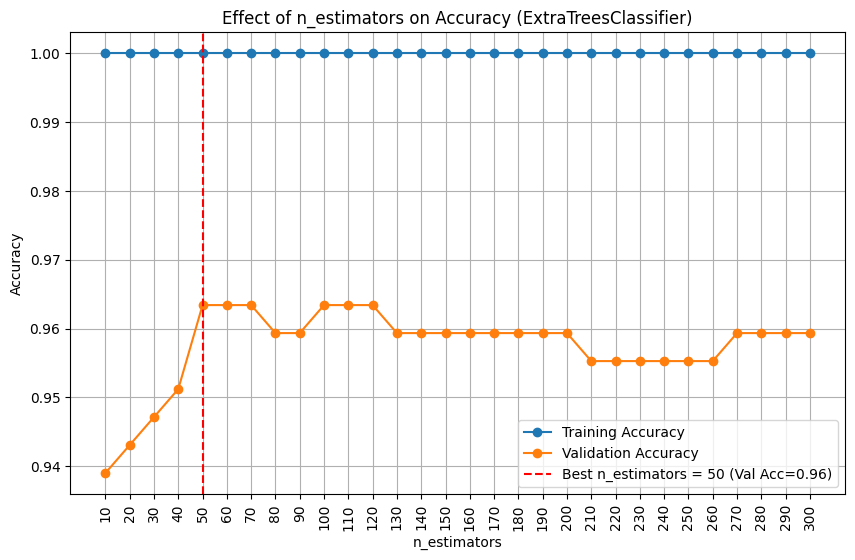

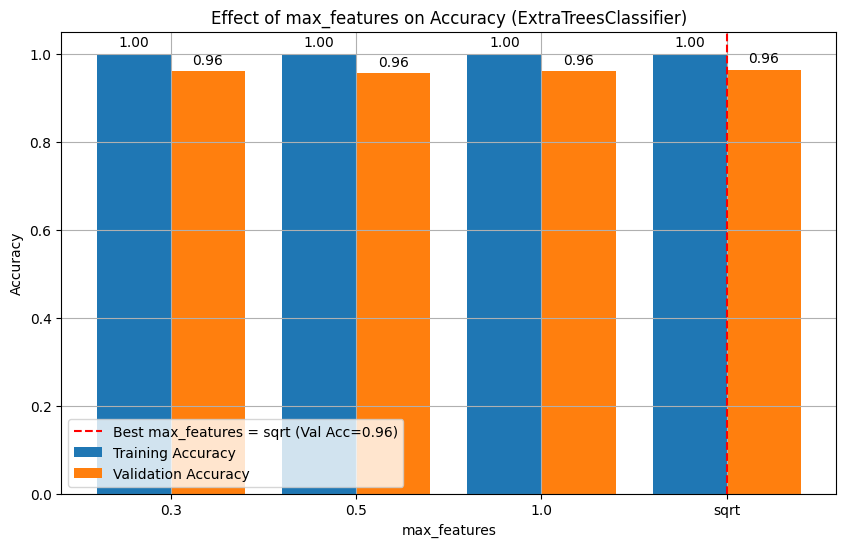

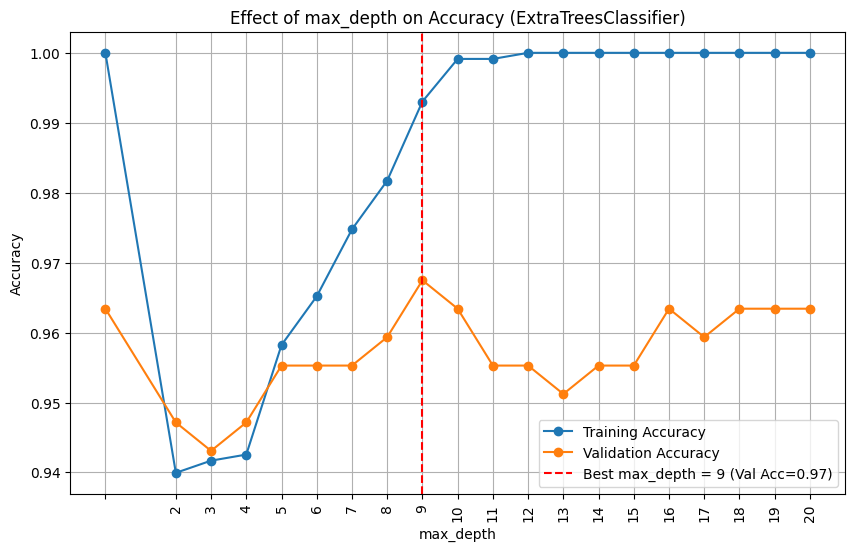

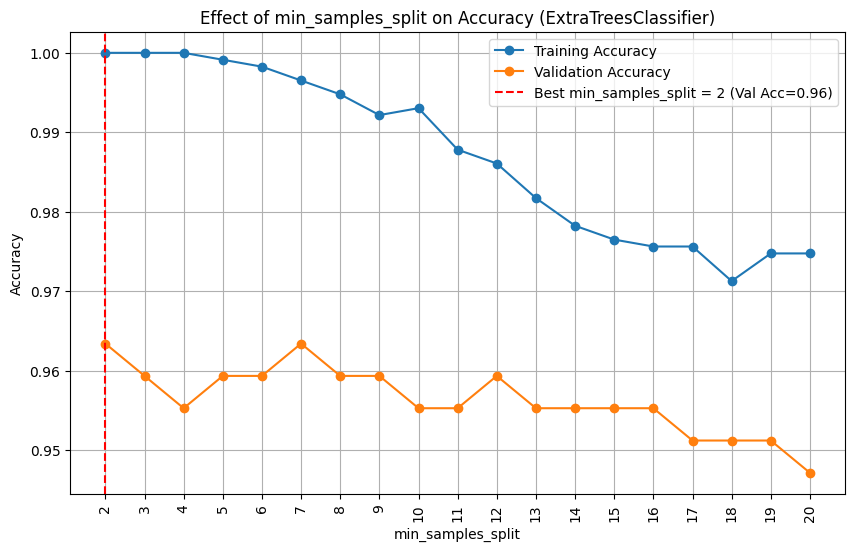

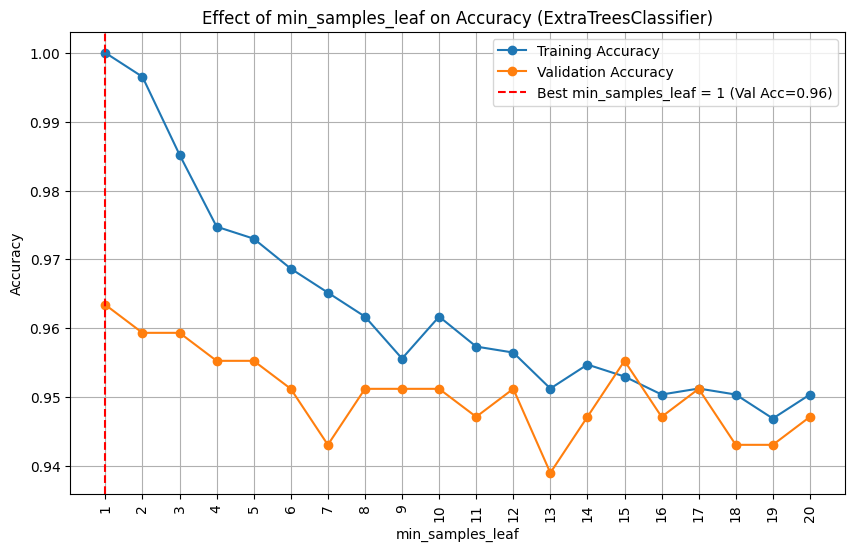

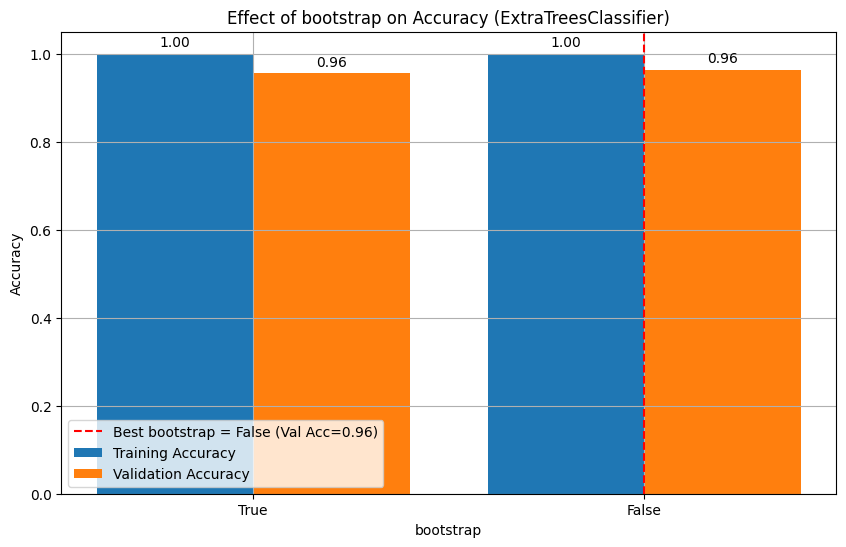

In [8]:
# Step 1
# Use plot_hyperparameter_vs_accuracy to explore the effect of each hyperparameter individually while keeping others at their default values.
# Identify the "interesting" ranges where the model’s performance (e.g., validation accuracy) changes significantly.

# IMPORTANT
plot_hyperparameter_vs_accuracy(
    model_class=ExtraTreesClassifier,
    hyperparameter_name="n_estimators",
    hyperparameter_values=list(range(10, 301, 10)),
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    fixed_params={"random_state": 42},
    categorical=False
)

# IMPORTANT: The size of the random subsets of features to consider when splitting a node.
# The lower the greater the reduction of variance, but also the greater the increase in bias.
# Empirical good default values are max_features=1.0 or equivalently max_features=None (always considering all features instead of a random subset) for regression problems,
# and max_features="sqrt" (using a random subset of size sqrt(n_features)) for classification tasks (where n_features is the number of features in the data).
# The default value of max_features=1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values (e.g. 0.3 is a typical default in the literature).
plot_hyperparameter_vs_accuracy(
    model_class=ExtraTreesClassifier,
    hyperparameter_name="max_features",
    hyperparameter_values=[0.3, 0.5, 1.0, "sqrt"],
    # hyperparameter_values=list(range(1, X_train.shape[1] + 1)),
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    fixed_params={"random_state": 42},
    categorical=True
)
# plot_hyperparameter_vs_accuracy(
#     model_class=ExtraTreesClassifier,
#     hyperparameter_name="max_features",
#     # hyperparameter_values=[0.3, 1.0, "sqrt", "log2"],
#     hyperparameter_values=list(range(1, X_train.shape[1] + 1)),
#     X_train=X_train,
#     y_train=y_train,
#     X_val=X_val,
#     y_val=y_val,
#     fixed_params={"random_state": 42},
#     categorical=False
# )

# Good results are often achieved when setting max_depth=None in combination with min_samples_split=2 (i.e., when fully developing the trees)
plot_hyperparameter_vs_accuracy(
    model_class=ExtraTreesClassifier,
    hyperparameter_name="max_depth",
    hyperparameter_values=[None] + list(range(2, 21)),
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    fixed_params={"random_state": 42},
    categorical=False
)

plot_hyperparameter_vs_accuracy(
    model_class=ExtraTreesClassifier,
    hyperparameter_name="min_samples_split",
    hyperparameter_values=list(range(2, 21)),
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    fixed_params={"random_state": 42},
    categorical=False
)

plot_hyperparameter_vs_accuracy(
    model_class=ExtraTreesClassifier,
    hyperparameter_name="min_samples_leaf",
    hyperparameter_values=list(range(1, 21)),
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    fixed_params={"random_state": 42},
    categorical=False
)

plot_hyperparameter_vs_accuracy(
    model_class=ExtraTreesClassifier,
    hyperparameter_name="bootstrap",
    hyperparameter_values=[True, False],
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    fixed_params={"random_state": 42},
    categorical=True
)

In [9]:
# Step 2
# Use a smaller, focused range of hyperparameter values based on the insights from the visual exploration.
# Perform a grid search with cross-validation to find the best combination of hyperparameters

param_grid = {
    "n_estimators": list(range(100, 251, 10)),  # Number of trees (IMPORTANT)
    "max_features": [0.3, 0.5, 1.0, "sqrt"],  # Number of features to consider for splits (IMPORTANT)
    "max_depth": [None],  # Maximum depth of trees
    "min_samples_split": [2],  # Minimum samples to split a node
    "min_samples_leaf": [1],  # Minimum samples at a leaf node
    "bootstrap": [True, False],  # Whether to use bootstrap samples
    "criterion": ["gini"],
    "random_state": [42]  # Reproducibility
}

# Initialize the Extra Trees model
rf = ExtraTreesClassifier()

# Define the GroupKFold object
group_kfold = GroupKFold(n_splits=5) # Data is divided into 5 folds, the model is trained and validated 5 times, each time using a different fold as the validation set and the remaining folds as the training set

# Perform grid search with GroupKFold
grid_search = GridSearchCV(rf, param_grid, cv=group_kfold, scoring="accuracy", n_jobs=-1)

# Combine training and validation data
X_train_final = pd.concat([X_train, X_val])
y_train_final = pd.concat([y_train, y_val])
groups_final = pd.concat([train_data["id"], val_data["id"]])

# Fit the grid search with groups
grid_search.fit(X_train_final, y_train_final, groups=groups_final)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Validation Accuracy:", grid_search.best_score_)  # Average validation accuracy across the 5 folds

# Evaluate best model on test set
test_predictions = grid_search.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, test_predictions))
print("Test Classification Report:\n", classification_report(y_test, test_predictions))

C:\Users\Aamid Mohsin\AppData\Roaming\Python\Python312\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 170, 'random_state': 42}
Best Validation Accuracy: 0.9505376344086022
Test Accuracy: 0.9116465863453815
Test Classification Report:
               precision    recall  f1-score   support

       pizza       0.96      0.87      0.91        83
    shawarma       0.86      0.94      0.90        83
       sushi       0.93      0.93      0.93        83

    accuracy                           0.91       249
   macro avg       0.91      0.91      0.91       249
weighted avg       0.91      0.91      0.91       249



In [10]:
# Take the best hyperparameters from the grid search and train the final model.
# best_params = {'bootstrap': True, 'max_depth': None, 'max_features': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 180, 'random_state': 42}
best_params = {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150, 'random_state': 42}

# Initialize Random Forest model
best_rf = ExtraTreesClassifier(**best_params)

# Train the model
best_rf.fit(X_train, y_train)

# Record test accuracy
test_predictions = best_rf.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, test_predictions))
print("Test Classification Report:\n", classification_report(y_test, test_predictions))
print("Log Loss:", log_loss(y_test, best_rf.predict_proba(X_test)))

Test Accuracy: 0.9156626506024096
Test Classification Report:
               precision    recall  f1-score   support

       pizza       0.96      0.88      0.92        83
    shawarma       0.87      0.93      0.90        83
       sushi       0.93      0.94      0.93        83

    accuracy                           0.92       249
   macro avg       0.92      0.92      0.92       249
weighted avg       0.92      0.92      0.92       249

Log Loss: 0.29467332718520245


In [11]:
# Estimates the model’s generalization error using samples not included in the bootstrap sample for each tree.
best_rf = ExtraTreesClassifier(**best_params, oob_score=True)
best_rf.fit(X_train, y_train)
print("OOB Score:", best_rf.oob_score_)

OOB Score: 0.9408181026979983


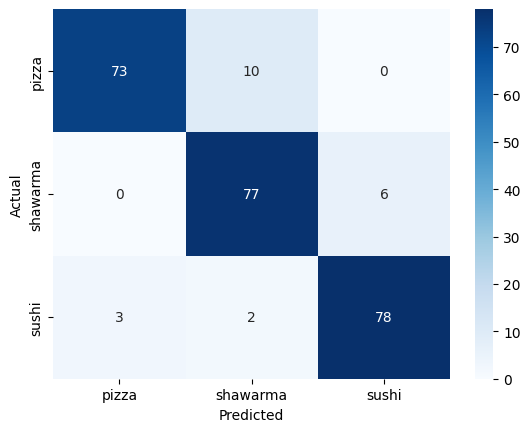

In [12]:
class_names = ["pizza", "shawarma", "sushi"]  
cm = confusion_matrix(y_test, test_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
# plt.savefig("visualizations/extratreesclassifier_confusion_mat.png")
plt.show()

In [13]:
# from skopt import BayesSearchCV
# from skopt.space import Integer, Categorical, Real

# # Define the parameter space
# param_space = {
#     # Number of trees
#     "n_estimators": Categorical(list(range(10, 201, 10))),

#     # Maximum depth of trees
#     "max_depth": Categorical([None] + list(range(8, 21))),  # [None, 8, 9, ..., 20]

#     # Minimum samples to split a node
#     "min_samples_split": Integer(2, 10),  # Range: 2 to 10

#     # Minimum samples at a leaf node
#     "min_samples_leaf": Integer(1, 5),  # Range: 1 to 5

#     # Number of features to consider for splits
#     "max_features": Categorical([None, "sqrt", "log2", 0.5, 0.8]),  # Common choices

#     # Whether to use bootstrap samples
#     "bootstrap": Categorical([True, False]),  # True or False
# }

# # Initialize the Random Forest model
# rf = RandomForestClassifier(random_state=42)

# # Define the GroupKFold object
# group_kfold = GroupKFold(n_splits=5)

# # Perform Bayesian optimization with GroupKFold
# bayes_search = BayesSearchCV(
#     rf, 
#     param_space,
#     n_iter=50,  # Number of iterations
#     cv=group_kfold,
#     scoring="accuracy",
#     n_jobs=-1,
#     random_state=42
# )

# # Combine training and validation data
# X_train_final = pd.concat([X_train, X_val])
# y_train_final = pd.concat([y_train, y_val])
# groups_final = pd.concat([train_data["id"], val_data["id"]])
# bayes_search.fit(X_train_final, y_train_final, groups=groups_final)

# # Best parameters and score
# print("Best Parameters:", bayes_search.best_params_)
# print("Best Validation Accuracy:", bayes_search.best_score_)

# # Evaluate best model on test set
# test_predictions = bayes_search.predict(X_test)
# print("Test Accuracy:", accuracy_score(y_test, test_predictions))
# print("Test Classification Report:\n", classification_report(y_test, test_predictions))